In [1]:
using LinearAlgebra

"""
Implementing Chris Chi's Kai monomer model in Julia.
Chris's model explicitly models KaiA binding to CI and KaiA binding to CII-KaiB.
This is desired for modeling a potential change in KaiC CII-CI allostery as a function of temperature
"""
function kaiabc_chi!(dXdt, X, p, t)
    # p is a named tuple with the following mandatory elements
    # ln_ks: natural log of the absolute value of a list of parameters. See below
    # fATP = [ATP]/([ATP] + [ADP])
    # Atot: total [KaiA]
    # M: Number of KaiA molecules could bind to CI ringh (with KaiB) per KaiC monomer
    # N: Number of KaiA molecules could bind to CII ring per KaiC monomer
    ln_ks, fATP, Atot, M, N = p.ln_ks, p.fATP, p.Atot, p.M, p.N
    
    # kCIIAoffU set to be 1. Actual value is absorbed in the units of time
    kCIIAoffU, kTU, kSU, kTUA, kSUA, kCIIAoffT, kDT, kUTA, kDTA, kCIIAoffD, kRelD00,
        kTDA, kSDA, kRelDA0, kCIIAoffS, kDS, kRelS00, kUSA, kDSA, kRelSA0,
        kCIhydD00, kCIIAoffDA0, kCIAoffD0A, kCIhydDA0, kSDA0, kCIAoffDAA, kCIhydS00, 
        kDS00, kCIIAoffSA0, kCIAoffS0A, kCIhydSA0, kDSA0, kCIAoffSAA, kCIIAoffDAA, 
        kSDAA, kDS0A, kCIIAoffSAA, kDSAA, kCIIAonU, kCIIAonT, kCIIAonD, kCIIAonS, 
        kCIIAonD00, kCIIAonS00, kCIAonD00, kCIAonDA0, kCIIAonD0A, kCIAonS00, 
        kCIAonSA0, kCIIAonS0A = exp.([0.; ln_ks])
    
    # Stoichiometry: how many molecules of KaiA does one molecule of each species have? (row vector)
    #         1       2       3       4       5       6       7       8       9       10      11      12      13      14      15      16
    #         U       UA      T       TA      D       DA      S       SA      D00     DA0     S00     SA0     D0A     DAA     S0A     SAA
    nA_vec = [0.      N       0.      N       0.      N       0.      N       0.      N       0.      N       M       N + M   M       N + M] 
    
    # Expand X by conservation law of KaiC ([KaiC]tot is nondimensionalized to be 1)
    Xfull = [1. - sum(X); X]
    
    # [KaiA]free
    # !!Af can be negative!!
    Af = Atot - nA_vec⋅Xfull    # a true dot product: gives a scalar
    
    # Rate matrices. Contributions to products only (to reactants will be calculated by conservation law)
    # phosphorylation and dephosphorylation
    #           1         2         3         4         5         6         7         8         9         10        11        12        13        14        15        16     
    #           U         UA        T         TA        D         DA        S         SA        D00       DA0       S00       SA0       D0A       DAA       S0A       SAA       
    pdp_r =    [0.        0.        kTU       0.        0.        0.        kSU       0.        0.        0.        0.        0.        0.        0.        0.        0.    # 1 d(U)dt
                0.        0.        0.        kTUA      0.        0.        0.        kSUA      0.        0.        0.        0.        0.        0.        0.        0.    # 2 d(UA)dt
                0.        0.        0.        0.        kDT       0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.    # 3 d(T)dt
                0.        kUTA*fATP 0.        0.        0.        kDTA      0.        0.        0.        0.        0.        0.        0.        0.        0.        0.    # 4 d(TA)dt
                0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.    # 5 d(D)dt
                0.        0.        0.        kTDA*fATP 0.        0.        0.        kSDA*fATP 0.        0.        0.        0.        0.        0.        0.        0.    # 6 d(DA)dt
                0.        0.        0.        0.        kDS       0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.    # 7 d(S)dt
                0.        kUSA*fATP 0.        0.        0.        kDSA      0.        0.        0.        0.        0.        0.        0.        0.        0.        0.    # 8 d(SA)dt
                0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.    # 9 d(D00)dt
                0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        kSDA0     0.        0.        0.        0.    # 10 d(DA0)dt
                0.        0.        0.        0.        0.        0.        0.        0.        kDS00     0.        0.        0.        0.        0.        0.        0.    # 11 d(S00)dt
                0.        0.        0.        0.        0.        0.        0.        0.        0.        kDSA0     0.        0.        0.        0.        0.        0.    # 12 d(SA0)dt
                0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.    # 13 d(D0A)dt
                0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        kSDAA # 14 d(DAA)dt
                0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        kDS0A     0.        0.        0.    # 15 d(S0A)dt
                0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        kDSAA     0.        0.]   # 16 d(SAA)dt
    
    # Bimolecular binding involving KaiA
    #               1         2         3         4         5         6         7         8         9         10        11        12        13        14        15        16 
    #               U         UA        T         TA        D         DA        S         SA        D00       DA0       S00       SA0       D0A       DAA       S0A       SAA  
    bindA_r =   Af*[0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.    # 1 d(U)dt
                    kCIIAonU  0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.    # 2 d(UA)dt
                    0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.    # 3 d(T)dt
                    0.        0.        kCIIAonT  0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.    # 4 d(TA)dt
                    0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.    # 5 d(D)dt
                    0.        0.        0.        0.        kCIIAonD  0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.    # 6 d(DA)dt
                    0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.    # 7 d(S)dt
                    0.        0.        0.        0.        0.        0.        kCIIAonS  0.        0.        0.        0.        0.        0.        0.        0.        0.    # 8 d(SA)dt
                    0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.    # 9 d(D00)dt
                    0.        0.        0.        0.        0.        0.        0.        0.       kCIIAonD00 0.        0.        0.        0.        0.        0.        0.    # 10 d(DA0)dt
                    0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.    # 11 d(S00)dt
                    0.        0.        0.        0.        0.        0.        0.        0.        0.        0.       kCIIAonS00 0.        0.        0.        0.        0.    # 12 d(SA0)dt
                    0.        0.        0.        0.        0.        0.        0.        0.       kCIAonD00  0.        0.        0.        0.        0.        0.        0.    # 13 d(D0A)dt
                    0.        0.        0.        0.        0.        0.        0.        0.        0.        kCIAonDA0 0.        0.       kCIIAonD0A 0.        0.        0.    # 14 d(DAA)dt
                    0.        0.        0.        0.        0.        0.        0.        0.        0.        0.       kCIAonS00  0.        0.        0.        0.        0.    # 15 d(S0A)dt
                    0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        kCIAonSA0 0.        0.       kCIIAonS0A 0.]   # 16 d(SAA)dt
    
    # Binding or unbinding that doesn't involve KaiA
    #           1         2         3         4         5         6         7         8         9         10        11        12        13        14        15        16
    #           U         UA        T         TA        D         DA        S         SA        D00       DA0       S00       SA0       D0A       DAA       S0A       SAA  
    bunb_r =   [0.        kCIIAoffU 0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        # 1 d(U)dt
                0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        # 2 d(UA)dt
                0.        0.        0.        kCIIAoffT 0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        # 3 d(T)dt
                0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        # 4 d(TA)dt
                0.        0.        0.        0.        0.        kCIIAoffD 0.        0.        kRelD00   0.        0.        0.        0.        0.        0.        0.        # 5 d(D)dt
                0.        0.        0.        0.        0.        0.        0.        0.        0.      kRelDA0     0.        0.        0.        0.        0.        0.        # 6 d(DA)dt
                0.        0.        0.        0.        0.        0.        0.        kCIIAoffS 0.        0.        kRelS00   0.        0.        0.        0.        0.        # 7 d(S)dt
                0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.      kRelSA0     0.        0.        0.        0.        # 8 d(SA)dt
                0.        0.        0.        0.   kCIhydD00*fATP 0.        0.        0.        0.      kCIIAoffDA0 0.        0.     kCIAoffD0A   0.        0.        0.        # 9 d(D00)dt
                0.        0.        0.        0.        0.   kCIhydDA0*fATP 0.        0.        0.        0.        0.        0.        0.      kCIAoffDAA  0.        0.        # 10 d(DA0)dt
                0.        0.        0.        0.        0.        0.   kCIhydS00*fATP 0.        0.        0.        0.      kCIIAoffSA0 0.        0.       kCIAoffS0A 0.        # 11 d(S00)dt
                0.        0.        0.        0.        0.        0.        0.   kCIhydSA0*fATP 0.        0.        0.        0.        0.        0.        0.      kCIAoffSAA  # 12 d(SA0)dt
                0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.      kCIIAoffDAA 0.        0.        # 13 d(D0A)dt
                0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        # 14 d(DAA)dt
                0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.      kCIIAoffSAA # 15 d(S0A)dt
                0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.]       # 16 d(SAA)dt
    
    r = pdp_r + bindA_r + bunb_r
    # Conservation law of KaiC
    r -= I(length(Xfull)).*sum(r, dims = 1)
    
    # Derivatives
    dXdt_full = r*Xfull
    
    dXdt[:] = dXdt_full[2:end]
    nothing
end


kaiabc_chi!

Example

In [2]:
import CSV
using DataFrames
using Plots; gr()
using DifferentialEquations

In [3]:
# read parameters
params = CSV.read("src/kaiabc_chi_params.csv", DataFrame);

dXdt at initial condition
[-0.09139833308392792, -5.184720299240308, 8.520647070034562, 4.662774548588138, 10.667956775539817, -0.26452316724252667, -21.76848672460819, 0.18523689333036564, -9.719602288836983, -2.941112136396169, 16.337268072865072, -2.230231160066755, 4.470516871011238, 1.4574035991143934, -0.11383664154069698]


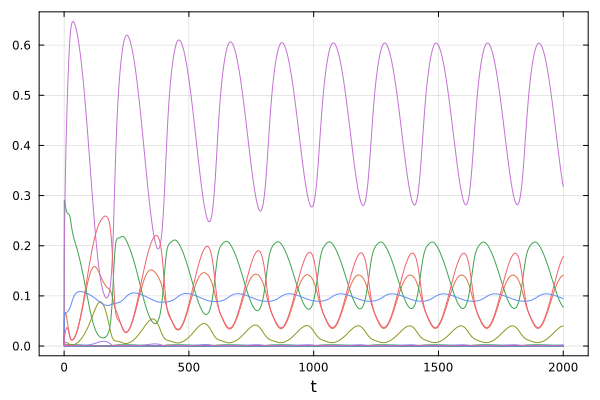

In [4]:
# collect the parameters
p = (ln_ks = Vector(params[3, :]),
    fATP = 1.0,
    Atot = 0.45,
    M = 1.,
    N = 1.)

# Initial condition
X0 = 0.02*ones(15)

# Initialize the derivative (values will be stored in place)
dXdt = zeros(15)

# Calculate the derivatives at initial condition
kaiabc_chi!(dXdt, X0, p, nothing)

println("dXdt at initial condition")
println(dXdt)

# initegrate and plot
tmax = 2e3
prob = ODEProblem(kaiabc_chi!, X0, (0., tmax), p)
sol = solve(prob, RadauIIA5())
plot(sol, legend=false, frame=:box, xlim=(-0.05tmax, 1.05tmax))

In [5]:
include("src/Utils.jl");
using Printf

In [6]:
# find the steady-state period
conv_t, Amp, per, ϕ = attracted_to(kaiabc_chi!, X0, 1000., p, burnin=500.)
println(@sprintf "Period = %.2f" per)

Period = 206.07
